In [1]:
# HIDDEN
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in Data 8.


def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_scatter(r):
    """Generate a scatter plot with a correlation approximately r"""
    plots.figure(figsize=(5,5))
    x, y = make_correlated_data(r)
    plots.scatter(x, y, color='darkblue', s=20)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)
    
def r_table(r):
    """
    Generate a table of 1000 data points with a correlation approximately r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

## Linear regression: defining the line

Let's write code to implement linear regression, using the equations we've seen in class.  The first two functions are copy-pasted from last time:

In [3]:
def standard_units(x):
    """ Converts an array x to standard units """
    return (x - np.mean(x)) / np.std(x)

def correlation(t, x, y):
    """ Computes correlation: t is a table, and x and y are column names """
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)

Now let's implement the formula for the slope and intercept:

In [4]:
def slope(t, x, y):
    """ Computes the slope of the regression line, like correlation above """
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    """ Computes the intercept of the regression line, like slope above """
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

In [5]:
example = r_table(0.5)
slope(example, 'x', 'y')

0.50226382816259152

## Height data and the regression line

We're going to apply this to the baby heights dataset for predicting the height of children.

In [6]:
family_heights = Table.read_table('family_heights.csv').drop(3)
parent_averages = (family_heights.column('father') + family_heights.column('mother'))/2
heights = Table().with_columns(
    'Parent Average', parent_averages,
    'Child', family_heights.column('childHeight')
)
heights.show(5)

Parent Average,Child
72.75,73.2
72.75,69.2
72.75,69
72.75,69
71,73.5


In [7]:
def nn_prediction(h):
    """Predict the height of a child 
    whose parents have a midparent height of h.
    
    The prediction is the average height of the children 
    whose midparent height is in the range h plus or minus 0.5 inches.
    """
    neighbors = heights.where(
        'Parent Average', are.between(h - 0.5, h + 0.5))
    return np.mean(neighbors.column('Child'))

In [8]:
heights_with_predictions = heights.with_column(
    'Nearest neighbor prediction', 
    heights.apply(nn_prediction, 'Parent Average'))

In [9]:
predicted_slope = slope(heights, 'Parent Average', 'Child')
predicted_slope

0.66449526235258838

In [10]:
predicted_intercept = intercept(heights, 'Parent Average', 'Child')
predicted_intercept

22.461839955758798

That gives us a linear regression model for predicting the height of the child from the height of the parents.

In [11]:
heights.take(100)

Parent Average,Child
67.5,73


We'll make a prediction for the height of the child of a couple whose parents have an average height of 67.5", first using the nearest neighbor prediction, then using the linear regression model we computed above.

In [12]:
nn_prediction(67.7)

67.55520833333334

In [13]:
predicted_slope * 67.5 + predicted_intercept

67.315270164558513

Let's visualize the graph of predictions, for both approaches to prediction.

In [14]:
heights_with_predictions = heights_with_predictions.with_column(
    'Regression prediction', 
    predicted_slope*heights.column('Parent Average') + predicted_intercept
)
heights_with_predictions

Parent Average,Child,Nearest neighbor prediction,Regression prediction
72.75,73.2,70.1,70.8039
72.75,69.2,70.1,70.8039
72.75,69,70.1,70.8039
72.75,69,70.1,70.8039
71,73.5,70.4158,69.641
71,72.5,70.4158,69.641
71,65.5,70.4158,69.641
71,65.5,70.4158,69.641
69.5,71,68.5025,68.6443
69.5,68,68.5025,68.6443


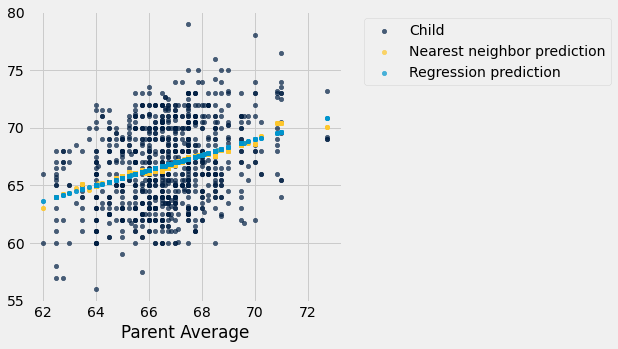

In [15]:
heights_with_predictions.scatter('Parent Average')

## Regression line vs other lines

Now we'll work with another dataset, illustrating the relationship between median income and education level across the country.

In [16]:
def demographics_errors(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)

In [17]:
def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

In [18]:
demographics = Table.read_table('district_demographics2016.csv')
demographics.show(5)

State,District,Median Income,Percent voting for Clinton,College%
Alabama,"Congressional District 1 (115th Congress), Alabama",47083,34.1,24
Alabama,"Congressional District 2 (115th Congress), Alabama",42035,33,21.8
Alabama,"Congressional District 3 (115th Congress), Alabama",46544,32.3,22.8
Alabama,"Congressional District 4 (115th Congress), Alabama",41110,17.4,17
Alabama,"Congressional District 5 (115th Congress), Alabama",51690,31.3,30.3


In [19]:
demographics = demographics.select('Median Income', 'College%')
demographics.show(5)

Median Income,College%
47083,24
42035,21.8
46544,22.8
41110,17
51690,30.3


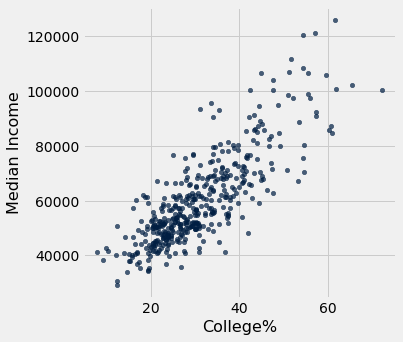

In [20]:
demographics.scatter('College%', 'Median Income')

Let's pause here for a moment to see what we can infer from this scatter plot.

We can use linear regression to infer a linear model to help us predict the median income of a congressional district, given the percentage of people with a college education.

In [21]:
correlation(demographics, 'College%', 'Median Income')

0.81846485171413352

In [22]:
regression_slope = slope(demographics, 'College%', 'Median Income')
regression_intercept = intercept(demographics, 'College%', 'Median Income')
regression_slope, regression_intercept

(1270.70168946388, 20802.577766677925)

In [23]:
predicted = fitted_values(demographics, 'College%', 'Median Income')

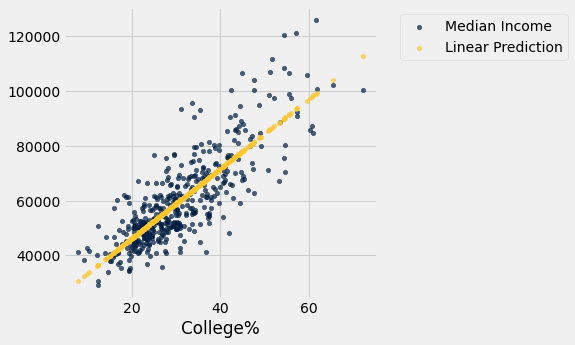

In [24]:
demographics = demographics.with_column(
    'Linear Prediction', predicted)
demographics.scatter('College%')

Of course the linear model is not perfect; there will typically be some errors in the predictions.  Let's measure how large those errors are, and visualize them.

In [25]:
actual = demographics.column('Median Income')
errors = actual - predicted

In [26]:
demographics.with_column('Error', errors)

Median Income,College%,Linear Prediction,Error
47083,24,51299.4,-4216.42
42035,21.8,48503.9,-6468.87
46544,22.8,49774.6,-3230.58
41110,17,42404.5,-1294.51
51690,30.3,59304.8,-7614.84
61413,36.7,67437.3,-6024.33
34664,19.4,45454.2,-10790.2
76440,29.6,58415.3,18024.7
50537,24.5,51934.8,-1397.77
49072,34,64006.4,-14934.4


It's tempting to measure the quality of a linear regression model by taking the average error.  However, this doesn't work: the average works out to zero, because the points above the line (where error is positive) are cancelled out by points below the line (where error is negative).

In [27]:
np.mean(errors)

6.3560089503211536e-13

Side question: It looks like the average was a very small number, not exactly zero.  Can you guess why that happened?

Intuitively, if your prediction is too large, that's as bad as if the prediction is too small.  So, it'd be natural to take the absolute value of the errors (to make them all positive, so they don't cancel each other out) and take the average of that.  But, for various reasons, instead we're going to take the square of the errors; that will also all make them positive and eliminate squaring.  (This might remind you of how we define the standard deviation.)

In [28]:
np.mean(errors ** 2) ** 0.5

9398.5155885712811

Let's visualize the errors.

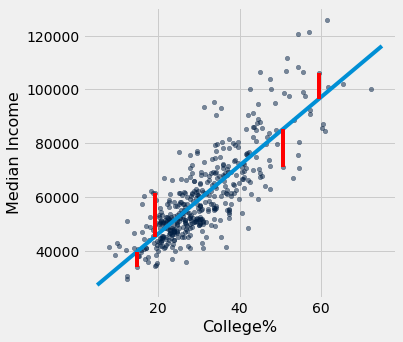

In [29]:
demographics_errors(regression_slope, regression_intercept)

What if we tried a different line?  Then the errors would look different:

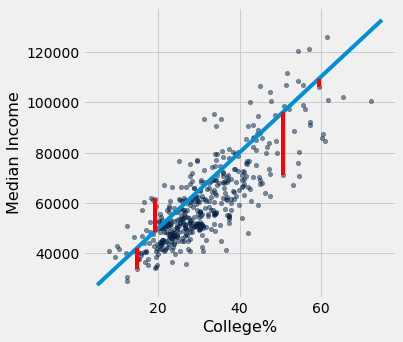

In [30]:
demographics_errors(1500, 20000)

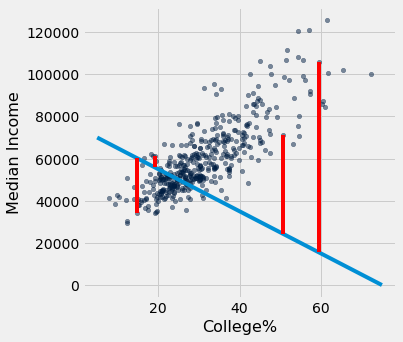

In [31]:
demographics_errors(-1000, 75000)

Ugh.  That last line looked like a terrible fit to the data; the prediction errors it would make are huge.

## Root Mean Square Error ##

Let's quantify that, by measuring the root-mean-square error.  A prediction line with a smaller root-mean-square error will tend to have a smaller prediction error, so smaller is better.

In [32]:
def show_demographics_rmse(slope, intercept):
    demographics_errors(slope, intercept)
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    prediction = slope * x + intercept
    mse = np.mean((y - prediction) ** 2)
    print("Root mean squared error:", round(mse ** 0.5, 2))

Root mean squared error: 30247.88


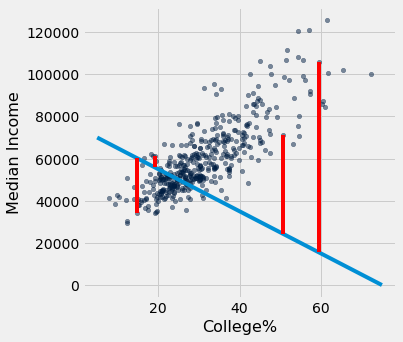

In [33]:
show_demographics_rmse(-1000, 75000)

Root mean squared error: 11559.09


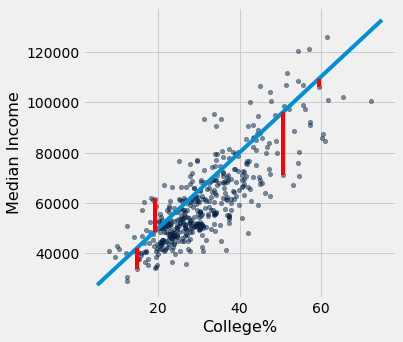

In [34]:
show_demographics_rmse(1500, 20000)

Root mean squared error: 9398.52


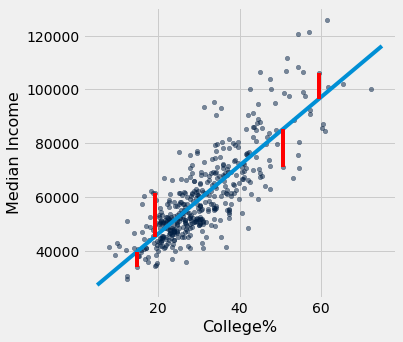

In [35]:
show_demographics_rmse(regression_slope, regression_intercept)

Which of those lines had the lowest root-mean-square error?

## Numerical Optimization ##

Let's take a bit of an aside.  We'll show you how to do numerical optimization.  In particular, if you have a function that computes how good a particular set of values are, numerical optimization will find the best values.  It will find inputs to the function that make the output of that function as small as possible.

How does it work?  Magic.  OK, it's not really magic -- you can take more advanced classes where you learn how to do this -- but that's beyond the scope of this class.  For our purposes, we'll take it for granted that someone else has figured out how to do this, and we'll use it for our needs.

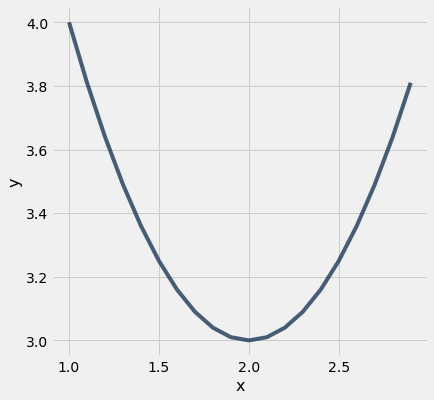

In [36]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
Table().with_columns('x', x, 'y', y).plot('x')

In [37]:
def f(x):
    return ((x-2)**2) + 3

In [38]:
minimize(f)

1.9999999946252267

In [39]:
def complicated_function(x):
    return 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 

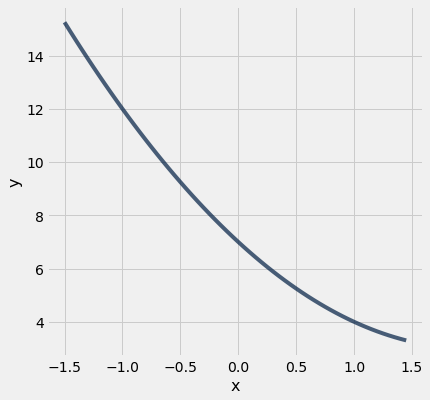

In [40]:
x = np.arange(-1.5, 1.5, 0.05)
y2 = f(x) 
Table().with_columns('x', x, 'y', y2).plot('x')

In [41]:
minimize(complicated_function)

-0.5126437620940081

## Minimizing RMSE ##

Now let's use numerical optimization to find the line (the slope and intercept) that minimize the root-mean-square prediction error.

In [42]:
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

In [43]:
demographics_rmse(1500, 20000)

11559.086490075999

In [44]:
demographics_rmse(-1000, 75000)

30247.883767944502

In [45]:
minimize(demographics_rmse)

array([  1270.70168805,  20802.57933807])

In [46]:
make_array(regression_slope, regression_intercept)

array([  1270.70168946,  20802.57776668])

Cool!  So the values that minimize the root-mean-square error, are exactly the ones that we computed using the formulas we showed you last lecture (using correlation and standard units).  This isn't an accident -- in fact, it always works out that way.

## Nonlinear Regression ##

A little bit of a digression: you can also use numerical optimization to make predictions when there is a nonlinear association among the data, if you have an idea for the nature of the association.  We'll work with a dataset that measures, for a bunch of athletes, how many kilograms they can lift, and how far they can throw a shot.

In [47]:
shotput = Table.read_table('shotput.csv')
shotput

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


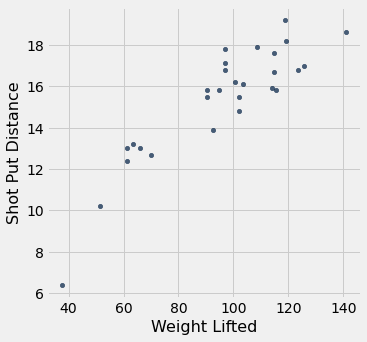

In [48]:
shotput.scatter('Weight Lifted')

We can fit a linear regression model to this data.

In [49]:
def shotput_linear_rmse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate) ** 2) ** 0.5

In [50]:
best_line = minimize(shotput_linear_rmse)
best_line

array([ 0.09834382,  5.95962883])

In [51]:
weights = shotput.column(0)

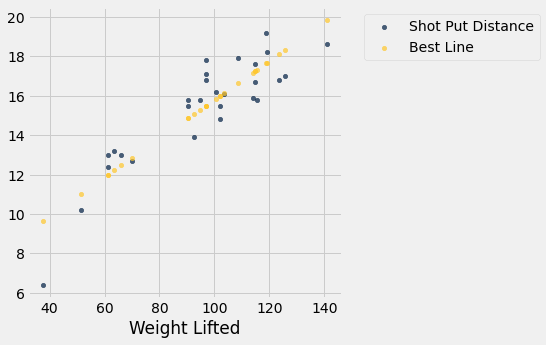

In [52]:
linear_fit = best_line.item(0)*weights + best_line.item(1)

shotput.with_column(
    'Best Line', linear_fit
).scatter(0)

Ugh.  That doesn't look like a very good fit.  You can see the predictions are systematically too low, on the left end.  The study that gathered this data hypothesized that there should be a quadratic relationship between weight lighted and shot put distance, so instead of fitting a line, let's fit a parabola -- a quadratic equation. 

A **quadratic Function** is given by the equation

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.  Let's try to find constants $a,b,c$ that yield a good fit to the data.

In [53]:
def shotput_quadratic_rmse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

In [54]:
best_quad = minimize(shotput_quadratic_rmse)
best_quad

array([ -1.04003731e-03,   2.82706003e-01,  -1.53167618e+00])

In [55]:
# x = weight lifted = 100 kg
# Then predicted shot put distance:

(-0.00104)*(100**2) + 0.2827*100 - 1.5318

16.3382

In [56]:
quad_fit = best_quad.item(0)*(weights**2) + best_quad.item(1)*weights + best_quad.item(2)

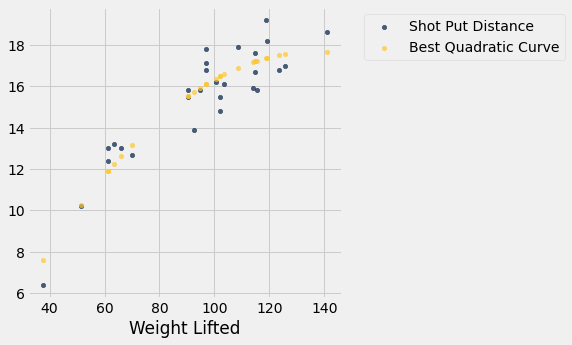

In [57]:
shotput.with_column('Best Quadratic Curve', quad_fit).scatter(0)